In [10]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

from importlib import reload 
import torch
import fasttext

In [18]:
corpus = lang_util.Corpus('/Users/jgordon/nta/datasets/PTB')

In [182]:
import rsm_samplers
import rsm
from ptb import lang_util
import rsm_experiment
reload(rsm_samplers)
reload(rsm)
reload(lang_util)
reload(rsm_experiment)

CONFIG = {
    'debug': False,
    'path': "/Users/jgordon/nta/results",
    'data_dir': "/Users/jgordon/nta/datasets",
    'dataset': 'ptb',
    'predictor_hidden_size': 1200,
    'predictor_output_size': 10000,
    'batch_size': 300,
    'batches_in_epoch': 2000,
    'batches_in_first_epoch': 2,
    'batch_log_interval': 2000,
    'vocab_size': 10000,
    'eval_interval': 3,
    'eval_batch_size': 100,
    'eval_batches_in_epoch': 824, #8243,
    'learning_rate': 0.0005,
    'm_groups': 1500,
    'n_cells_per_group': 1,
    'k_winners': 80,
    'k_winner_cells': 1,
    'pred_l2_reg': 0.000001,
    'dec_l2_reg': 0.000001,
    'input_bias': True,
    'eval_interval': 5,
    'eps': 0.5,
    'gamma': 0.0,
    'forget_mu': 0.025,
    'weight_sparsity': None,
    'mult_integration': False,
    'fpartition': None,
    'boost_strength': 0.5,
    'boost_strength_factor': 0.85,
    'boost_strat': 'col_boosting',
    'do_inhibition': False,
    'x_b_norm': True,
    'balance_part_winners': True,
    'decode_activation_fn': None,
    'decode_bias': False,
    'embed_dim': 100,
    'input_size': (1, 100),
    'output_size': 100,
    'embedding_kind': 'ptb_fasttext_e5',
    'max_decay': 0.95,
    'mem_floor': 0.0005,
    'trainable_decay': True,
    'word_cache_decay': 0.99
}
    
exp = rsm_experiment.RSMExperiment(config=CONFIG)

In [183]:
exp.model_setup(CONFIG, restore_path="/Users/jgordon/Desktop/checkpoint_47")

setup: Using cpu
Maybe download PTB...


Loaded embedding dict (ptb_fasttext_e5) with 10000 entries
Built dataloaders...
Loading from /Users/jgordon/Desktop/checkpoint_47


In [184]:
wcs = []
uss = []
ppls = []

for wc in torch.arange(0.001, .11, 0.01):
    for us in torch.arange(0.001, .11, 0.01):
        print("wc: %s, us: %s" % (wc.item(), us.item()))
        exp.word_cache_pct = wc.item()
        exp.unif_smoothing = us.item()
        ret = exp.eval_epoch(0)
        int_ppl = ret['val_interp_ppl']
        ppls.append(int_ppl)
        wcs.append(wc.item())
        uss.append(us.item())
        print(ret)

wc: 0.0010000000474974513, us: 0.0010000000474974513
Evaluating...
Finished batch 0
Partial pred acc - batch acc: 13.000%, pred ppl: 438.4
Targ: it    was n't black monday <eos> but while the new   york stock exchange did       n't fall apart friday as  the  
Pred: <unk> is  a   <unk> and    <eos> the the   the <unk> york city  exchange composite n't have N     <eos>  the much 
{'val_loss': 0.03921883683922945, 'val_interp_ppl': 118.76658421766986, 'val_pred_ppl': 120.32726463057718, 'val_pred_acc': 23.4126213592233}
wc: 0.0010000000474974513, us: 0.010999999940395355
Evaluating...
Finished batch 0
Partial pred acc - batch acc: 13.000%, pred ppl: 412.9
Targ: pit  in    chicago waves of    selling continued to hit stocks themselves on    the big    board and   specialists continued to <unk> 
Pred: days <eos> the     <eos> <eos> N       the       to the the    <eos>      <eos> the market board <eos> the         <eos>     to the   
{'val_loss': 0.039216615883543075, 'val_interp_ppl': 118.

Targ: corp. and <unk> corp. the successor company to    <unk> hotels <eos> <unk> officials could n't be located <eos> financial corp.    
Pred: &     and <unk> <unk> and <unk>     <unk>   <eos> be    the    <eos> the   inc.      said  n't be reached to    the       services 
{'val_loss': 0.03921774517997954, 'val_interp_ppl': 116.30628141164826, 'val_pred_ppl': 120.3916183935955, 'val_pred_acc': 23.413834951456312}
wc: 0.010999999940395355, us: 0.050999999046325684
Evaluating...
Finished batch 0
Partial pred acc - batch acc: 15.000%, pred ppl: 410.4
Targ: portions of kansas he  said <eos> the soviet  union has n't  given any clear indication of its wheat purchase plans 
Pred: <eos>    of <unk>  and says <eos> the company union has been been  the <unk> that       of the <unk> <eos>    of    
{'val_loss': 0.039221584263429476, 'val_interp_ppl': 116.86985649562938, 'val_pred_ppl': 120.40940862657169, 'val_pred_acc': 23.4126213592233}
wc: 0.010999999940395355, us: 0.061000000685453415
Eval

{'val_loss': 0.039218548350759504, 'val_interp_ppl': 117.33168989086958, 'val_pred_ppl': 120.40791177007176, 'val_pred_acc': 23.4126213592233}
wc: 0.020999999716877937, us: 0.09099999815225601
Evaluating...
Finished batch 0
Partial pred acc - batch acc: 18.000%, pred ppl: 393.3
Targ: lacked enough financial information about <unk> and   the   <unk> and sent  the cases back to federal district court in    dallas 
Pred: was    a      to        instruments <eos> the   <eos> <unk> <unk> of  <unk> the <unk> of   to the     reserve  court <eos> new    
{'val_loss': 0.03921832519049928, 'val_interp_ppl': 118.02297564703989, 'val_pred_ppl': 120.37109239996997, 'val_pred_acc': 23.41626213592233}
wc: 0.020999999716877937, us: 0.10100000351667404
Evaluating...
Finished batch 0
Partial pred acc - batch acc: 18.000%, pred ppl: 373.0
Targ: <unk> 's    civil war <eos> details of the talks described by a   <unk> official as very delicate were n't disclosed 
Pred: <eos> <eos> <unk> war <eos> the     of

Targ: public enthusiasm for   stock mutual funds <eos> the main  thing was portfolio insurance a   mechanical trading system intended to protect 
Pred: <eos>  relations  <eos> the   <eos>  funds <eos> the <unk> <unk> is  a         that      and <unk>      <unk>   firm   that     to buy     
{'val_loss': 0.03921799302028799, 'val_interp_ppl': 112.64136776253285, 'val_pred_ppl': 120.38201770694134, 'val_pred_acc': 23.41626213592233}
wc: 0.04100000113248825, us: 0.03099999949336052
Evaluating...
Finished batch 0
Partial pred acc - batch acc: 20.000%, pred ppl: 294.5
Targ: do    well during periods of    economic weakness <eos> frank <unk> <eos> many  people now claim to   have predicted the  N     
Pred: <unk> n't  <eos>  the     <eos> the      <unk>    <eos> the   <unk> a     <unk> of     are <unk> that be   a         that <unk> 
{'val_loss': 0.03921591392401787, 'val_interp_ppl': 113.0393021595552, 'val_pred_ppl': 120.3513107545386, 'val_pred_acc': 23.41626213592233}
wc: 0.0410000011324

{'val_loss': 0.03921951383840546, 'val_interp_ppl': 114.53036192001893, 'val_pred_ppl': 120.4355651902488, 'val_pred_acc': 23.408980582524272}
wc: 0.050999999046325684, us: 0.07100000232458115
Evaluating...
Finished batch 0
Partial pred acc - batch acc: 21.000%, pred ppl: 229.5
Targ: <unk> operations <eos> still some industry  giants   are expected to report continuing gains  largely because so much of their business 
Pred: board <eos>      <eos> the   the  investors analysts are <unk>    to be     a          growth in      because of far  of the   sales    
{'val_loss': 0.03921926064977368, 'val_interp_ppl': 115.17651643046683, 'val_pred_ppl': 120.42565802595625, 'val_pred_acc': 23.40776699029126}
wc: 0.050999999046325684, us: 0.08100000023841858
Evaluating...
Finished batch 0
Partial pred acc - batch acc: 21.000%, pred ppl: 241.4
Targ: the market 's afternoon surge <eos> among classes for   which details were available yields ranged from N N or N 
Pred: the week   's <unk>     crash 

Targ: small wonder    that britain 's labor party      wants credit controls <eos> a   few   hours after the party launched its own   
Pred: the   investors the  's      's <unk> department is    to     <unk>    to    the <unk> years of    the <unk> 's       a   <unk> 
{'val_loss': 0.03922336633109207, 'val_interp_ppl': 111.8058954631915, 'val_pred_ppl': 120.39594570326979, 'val_pred_acc': 23.402912621359224}
wc: 0.07100000232458115, us: 0.010999999940395355
Evaluating...
Finished batch 0
Partial pred acc - batch acc: 20.000%, pred ppl: 255.8
Targ: rule on    sony 's  renewed request for   a pre-trial order blocking sale of the disputed products on  which deliveries began 
Pred: N    <eos> the  and <unk>   <unk>   <eos> a <unk>     <eos> <eos>    a    to the company  <eos>    and the   the        in    
{'val_loss': 0.03922227668367977, 'val_interp_ppl': 112.03266774361795, 'val_pred_ppl': 120.43070291919928, 'val_pred_acc': 23.398058252427184}
wc: 0.07100000232458115, us: 0.0209999997

{'val_loss': 0.039221596953829804, 'val_interp_ppl': 113.36955401175263, 'val_pred_ppl': 120.39220932132483, 'val_pred_acc': 23.401699029126213}
wc: 0.08100000023841858, us: 0.050999999046325684
Evaluating...
Finished batch 0
Partial pred acc - batch acc: 22.000%, pred ppl: 223.7
Targ: healthy metropolitan areas will  create significant opportunities for   corporations and   professional service  firms looking for bargains as    the <unk> industry 
Pred: <unk>   of           of    <eos> be     a           <unk>         <eos> the          <eos> <unk>        services <eos> <eos>   for the      <eos> a   <unk> <eos>    
{'val_loss': 0.039220211878238084, 'val_interp_ppl': 113.922196204671, 'val_pred_ppl': 120.39466674321089, 'val_pred_acc': 23.399271844660195}
wc: 0.08100000023841858, us: 0.061000000685453415
Evaluating...
Finished batch 0
Partial pred acc - batch acc: 22.000%, pred ppl: 215.8
Targ: keating wanted <eos> he  became very angry at    that left my  office and told  a   number

Targ: the   price   of polyethylene even  more   than that of  other commodity plastics has taken a    dive  <eos> benchmark grades which 
Pred: <eos> company of the          <eos> though than N    the the   <unk>     markets  and been  over <unk> <unk> in        N      of    
{'val_loss': 0.03922131850872442, 'val_interp_ppl': 116.92822866556084, 'val_pred_ppl': 120.3955353893933, 'val_pred_acc': 23.396844660194176}
wc: 0.09099999815225601, us: 0.10100000351667404
Evaluating...
Finished batch 0
Partial pred acc - batch acc: 22.000%, pred ppl: 203.4
Targ: marketing <eos> through a   venture with its   investment banker first boston corp. quantum completed in  august an    acquisition of <unk> 
Pred: <eos>     a     the     the <unk>   with <unk> <unk>      in     to    boston corp. said    corp.     the N      <eos> earlier     of <unk> 
{'val_loss': 0.03922362123317655, 'val_interp_ppl': 117.68994786500437, 'val_pred_ppl': 120.37129457276323, 'val_pred_acc': 23.400485436893202}
wc: 0.

Best values cache 0.05999999865889549 unif 0.0005000000237487257


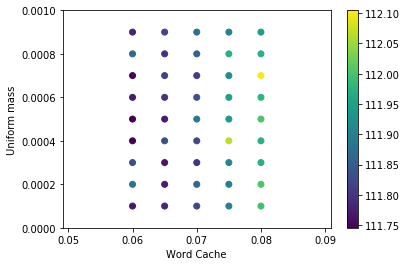

In [193]:
import matplotlib.pyplot as plt
import numpy as np

plt.scatter(wcs[-45:], uss[-45:], c=ppls[-45:])
plt.xlabel("Word Cache")
plt.ylabel("Uniform mass")
plt.ylim(0, .001)
plt.colorbar()

idx = np.argmin(ppls)
print("Best values", 'cache', wcs[idx], 'unif', uss[idx])

In [186]:
for wc in torch.arange(0.06, .08, 0.005):
    for us in torch.arange(0.0001, .001, 0.0001):
        print("wc: %s, us: %s" % (wc.item(), us.item()))
        exp.word_cache_pct = wc.item()
        exp.unif_smoothing = us.item()
        ret = exp.eval_epoch(0)
        int_ppl = ret['val_interp_ppl']
        ppls.append(int_ppl)
        wcs.append(wc.item())
        uss.append(us.item())
        print(ret)

wc: 0.05999999865889549, us: 9.999999747378752e-05
Evaluating...
Finished batch 0
Partial pred acc - batch acc: 19.000%, pred ppl: 244.5
Targ: recommendation by investment canada  <eos> spokesmen for merieux and   connaught said they had   n't been informed of specific areas   of 
Pred: year           of the        banking 's    the       for the     corp. the       said the  would n't been <unk>    to the      actions to 
{'val_loss': 0.03922100944299866, 'val_interp_ppl': 111.76826118477572, 'val_pred_ppl': 120.40362554597664, 'val_pred_acc': 23.393203883495147}
wc: 0.05999999865889549, us: 0.00019999999494757503
Evaluating...
Finished batch 0
Partial pred acc - batch acc: 19.000%, pred ppl: 232.4
Targ: does  n't make earnings projections <eos> mr. <unk> said he  estimated that lilly 's earnings for the quarter jumped about 
Pred: <eos> n't have a        <eos>       <eos> the <unk> said the expects   that the   's earnings for the quarter ended  N     
{'val_loss': 0.0392279460782058

Targ: programs second says brian <unk> a former director of programs for the british broadcasting corp <eos> given a   choice everybody 
Pred: express  <eos>  and  <unk> <unk> a former <unk>    of the      at  the <unk>   industry     co.  <eos> mr.   the <unk>  of        
{'val_loss': 0.03922310983310047, 'val_interp_ppl': 111.81499121093582, 'val_pred_ppl': 120.43576252023365, 'val_pred_acc': 23.395631067961165}
wc: 0.06499999761581421, us: 0.0007999999797903001
Evaluating...
Finished batch 0
Partial pred acc - batch acc: 17.000%, pred ppl: 237.4
Targ: consortium bid however would <unk> <unk> 's    direct role  in ferranti and   might consequently <unk> ministry officials <eos> a   british   
Pred: year       of  <eos>   <eos> be    the   <eos> <unk>  <unk> in the      <eos> the   be           be    the      officials said  the spokesman 
{'val_loss': 0.03922100602513523, 'val_interp_ppl': 111.79663094363114, 'val_pred_ppl': 120.40701034732383, 'val_pred_acc': 23.396844660194176}
wc:

Targ: N     N N     to N N N five  months N N N to N N N six months <eos> london 
Pred: <eos> N <eos> to N N N <eos> months N N N to N N N six months N     london 
{'val_loss': 0.03923229495678278, 'val_interp_ppl': 112.06547507403715, 'val_pred_ppl': 120.63535499524893, 'val_pred_acc': 23.37135922330097}
wc: 0.07500000298023224, us: 0.0005000000237487257
Evaluating...
Finished batch 0
Partial pred acc - batch acc: 17.000%, pred ppl: 194.1
Targ: in    the next few days   <eos> it  can happen before you can turn around <eos> he  said he  <unk> many 
Pred: <eos> the week few months <eos> the 's  be     to     the can be   out    the   the says the says  the  
{'val_loss': 0.03922067803683356, 'val_interp_ppl': 111.93839202751803, 'val_pred_ppl': 120.49455381710146, 'val_pred_acc': 23.394417475728154}
wc: 0.07500000298023224, us: 0.0006000000284984708
Evaluating...
Finished batch 0
Partial pred acc - batch acc: 17.000%, pred ppl: 197.7
Targ: <eos> he  termed <unk> 's    legal actions as  